# Standardization

Most features in our data are just numbers without units attached to them. However, giving a length in [cm or inch][1] will give different values and thus different outputs when feeding these numbers e.g. to a neural network. In addition, the values of different features may cover completely different natural ranges. This may have a large effect on the performance of machine learning models, because if a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly.
The `sklean` documentation provides further information on [preprocessing of data][2].

[1]: https://en.wikipedia.org/wiki/Mars_Climate_Orbiter#Cause_of_failure
[2]: https://scikit-learn.org/stable/modules/preprocessing.html

Some algorithms will be more susceptible to the scaling of the data than others. 
Neural networks expect all input features to vary in a similar way, and ideally to look like standard normally distributed data, i.e. Gaussian with zero mean and unit variance.
BDTs that just apply `if` statements on the features are typically very robust.

### Example
One example that illustrates the importance of preprocessing the data to rescale feature values to "standard ranges" is the application of SVMs to the `sklearn`'s cancer dataset:

In [ ]:
# import SVC and load data
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

The features in this dataset have very different ranges as illustrated by the following plot.

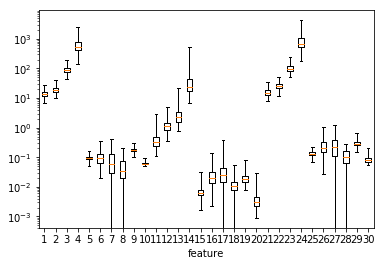

In [44]:
# plot features
import matplotlib.pyplot as plt
plt.boxplot(cancer.data, whis = "range")
plt.xlabel("feature")
plt.yscale("log")

In [11]:
# fit data without rescaling
svm = SVC()
svm.fit(X_train, y_train).score(X_test, y_test)

0.6293706293706294

In [15]:
# now rescale the features and retrain
from sklearn.preprocessing import MinMaxScaler
# compute minimum and maximum on the training data
# note that we must train the scaler only on the training data (but not the full dataset)
scaler = MinMaxScaler().fit(X_train)
# rescale the training data
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)
# retrain
svm.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

0.951048951048951

In [20]:
# same effect (although much smaller) e.g. on MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000, random_state=0)
print "Score using unscaled data:", mlp.fit(X_train, y_train).score(X_test, y_test)
print "Score using rescaled data:", mlp.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

Score using unscaled data: 0.9300699300699301
Score using rescaled data: 0.965034965034965


In [22]:
# no effect e.g. on BDT
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0)
print "Score using unscaled data:", dt.fit(X_train, y_train).score(X_test, y_test)
print "Score using rescaled data:", dt.fit(X_train_scaled, y_train).score(X_test_scaled, y_test)

Score using unscaled data: 0.8811188811188811
Score using rescaled data: 0.8811188811188811


### Example II

Large features values may also lead to convergence issues.

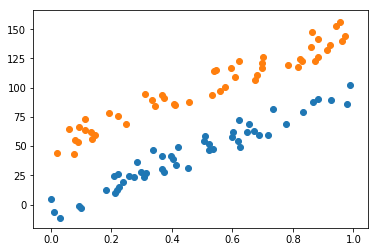

In [34]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(85)
nsamples = 50
pops     = 2
yshift   = 0.5
yscale   = 100 # <- change this
noise    = 0.3

### helpers
def MakeXYcorrSample(x0 = 0, y0 = 0, noise = noise, yscale = yscale, pops = pops, yshift = yshift):
  # space
  X = np.zeros((nsamples * pops, 2))
  y = np.zeros(nsamples * pops)
  # fill
  X[:, 0] = x0 + np.random.rand(nsamples * pops)
  for n in range(pops):
    X[n*nsamples:(n+1)*nsamples, 1] = yscale * (y0 + X[n*nsamples:(n+1)*nsamples, 0] - noise/2. + noise * np.random.rand(nsamples) + n*yshift)
    y[n*nsamples:(n+1)*nsamples] = n
  return X, y

### make and plot dataset
X, y = MakeXYcorrSample()
for pop in range(pops):
  plt.scatter(*X[y == pop,0:2].T)

Score on training data: 0.9733333333333334
Score on validation data: 0.92


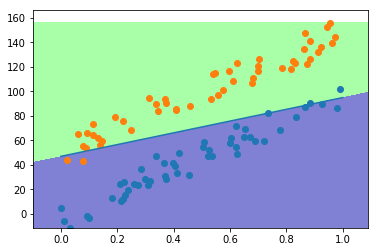

In [35]:
### prepare data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

### fit
from sklearn.svm import LinearSVC

model = LinearSVC().fit(X_train, y_train)

print "Score on training data:", model.score(X_train, y_train)
print "Score on validation data:", model.score(X_test, y_test)

### visualize
for pop in range(pops):
  plt.scatter(*X[y == pop,0:2].T)
if "coef_" in dir(model):
  eps = 0.1
  x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
  y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps  
  xx = np.linspace(x_min, x_max, 1000)
  yy = np.linspace(y_min, y_max, 1000)
  X1, X2 = np.meshgrid(xx, yy)
  X_grid = np.c_[X1.ravel(), X2.ravel()]
  decision_values = model.predict(X_grid)
  from matplotlib.colors import ListedColormap
  plt.gca().imshow(decision_values.reshape(X1.shape), extent=(x_min, x_max, y_min, y_max), aspect='auto', origin='lower', alpha=0.5, cmap = ListedColormap(['#0000aa', '#ff2020', '#50ff50']))
  #
  line = np.linspace(0, 1)
  for coef, intercept in zip(model.coef_, model.intercept_):
    ax = plt.plot(line, -(line * coef[0] + intercept) / coef[1])